In [1]:
# Library imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# Loading and parsing dataset

In [2]:
# Loading datasets
## Parsing first 2 columns ('Date' and 'Time' as one column 'datetime')
## Made 'datetime' the index
dataset = pd.read_csv('household_power_consumption.txt', sep=";", header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime': [0,1]}, index_col=['datetime'])

In [3]:
# Working the missing values
dataset.replace('?', np.nan, inplace=True)
# Making it numeric
dataset = dataset.astype('float32')

In [4]:
# The datetime runs every minute
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [5]:
# Filling NaN values
## Taking in observations from the same time the day before
def fill_missing(values):
    one_day = 60*24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row,col]):
                values[row, col] = values[row - one_day, col]

fill_missing(dataset.values)

In [6]:
# Adding a new Attribute
## Removing teh sub_mettering_1, 2, and 3 from the the global_active_power will give us the reaminds of kW/h used in the house
dataset['sub_metering_4'] = (dataset['Global_active_power'] * 1000/60) - (dataset['Sub_metering_1'] + dataset['Sub_metering_2'] + dataset['Sub_metering_2'])

In [7]:
dataset.to_csv('household_power_consumption.csv')

In [8]:
# Resampling minute data to total for each day, from the new CSV dataset
dataset = pd.read_csv('household_power_consumption.csv', header=0,infer_datetime_format=True,parse_dates=['datetime'], index_col=['datetime'])
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

daily_data.to_csv('household_power_consumption_daily.csv')

# Evaluation Metric

In [9]:
# Evaluating one or more weeks against expected values
# Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.

def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# Train and test sets

In [10]:
# Splitting Univariate dataset into train/test sets
## We'll use final year (2010ish) for evaluating the model (test)
## We'll use three years of data (2016-2019ish) for training the model (train)

init_train = 1
end_train = 328
init_test = 328
end_test = 6

def split_dataset(data):
    train, test = data[init_train:-end_train], data[-init_test:-end_test]
    # Restructuring into windows of weekly data:
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [11]:
dataset_daily = pd.read_csv('household_power_consumption_daily.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col='datetime')
train, test = split_dataset(dataset_daily.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


# Walk-forward validation

In [12]:
# Evaluating a single model
def evaluate_model(train, test, n_input):
    # fitting the model
    model = build_model(train, n_input)
    # history is the list of weekly data
    history = [x for x in train]
    # Walk-forward validation for each week:
    predictions = list()
    for i in range(len(test)):
        # predict week
        yhat_sequence = forecast(model, history, n_input)
        # Storing
        predictions.append(yhat_sequence)
        # Getting real observations and add to history for predicting the next week:
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:,:, 0], predictions)
    return score, scores


In [13]:
def summarize_scores(name, score, scores):
    s_scores = ','.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# Univariate

In [14]:
# Iterating over the timesteps and dividing data into overlapping windows
# Each iteration moves along one time step and predicts the subsequente 7 days:
def series_to_supervised(train, n_input, n_out=7):
    #flattening data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # stepping over the history, one step at a time
    for _ in range(len(data)):
        # defining the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensuring we have enough data for this
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # moving along one step at a time
        in_start += 1
    return np.array(X), np.array(y)

# Fitting the model

In [15]:
# Training the model
def build_model(train, n_input):
    # preparing the data
    train_x, train_y = series_to_supervised(train, n_input)
    # defining parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # defining the model
    model = Sequential()
    model.add(LSTM(
        200,
        activation='relu',
        input_shape=(n_timesteps, n_features)
    ))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse',optimizer='adam')
    #Fitting network
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

# Predicting

In [16]:
# making a forecast
def forecast(model, history, n_input):
    # flatenning the data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # getting last observation for input
    input_x = data[-n_input:,0]
    # reshaping into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # running the forecaster
    yhat = model.predict(input_x, verbose=0)
    # getting the vector forecast
    yhat_vector = yhat[0]
    return yhat_vector

# Running all

In [17]:
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)

lstm: [404.956] 419.1,403.1,399.5,404.9,419.1,351.2,432.7


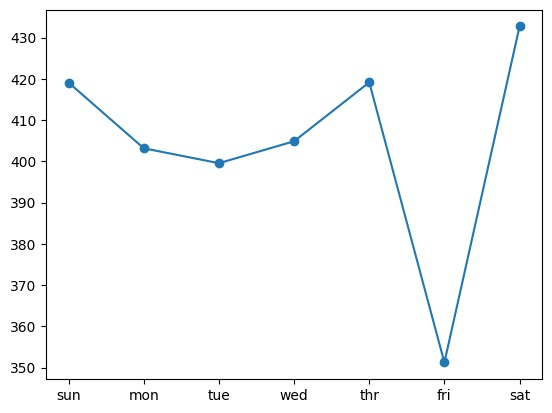

In [18]:
# summarizing scores
summarize_scores('lstm', score, scores)
# Plotting scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()